In [287]:
from typing import List, NamedTuple, Text
import itertools

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from statsmodels.gam import api as gam
from statsmodels.nonparametric import kernel_regression

np.random.seed(2020)

In [273]:
def f_linear(x):
    x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
    return x1 + x2 + x3

def f_nonlinear(x):
    x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
    return np.sin(4 * x1) + 2 * np.sqrt(x2) + np.exp(x3)

def f_geo_mean(x):
    x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
    return np.power(x1 * x2 * x3, 1./3.)

In [267]:
def run_trial(n, f, model):
    x = np.random.uniform(size=[n, 3])
    epsilon = np.random.normal(size=n)
    z = f(x)
    y = z + epsilon
    if model == 'linear':
        model = sm.OLS(y, sm.add_constant(x)).fit()
        return np.mean(np.square(model.predict(sm.add_constant(x)) - z))
    if model == 'gam':
        model = gam.GLMGam(
            y, sm.add_constant(x),
            smoother=gam.BSplines(x, df=[4] * 3, degree=[3] * 3)).fit()
        return np.mean(np.square(model.predict(sm.add_constant(x), x, transform=True) - z))
    if model == 'kernel_reg':
        model = kernel_regression.KernelReg(y, x, ['c'] * 3, bw=[0.5] * 3)
        return np.mean(np.square(model.fit()[0] - z))    
    raise ValueError(f'Unknown model: {model}.')

In [286]:
Trial = NamedTuple('Trail', [('f', Text), ('model', Text), ('mse', float)])
trials = []  # type: List[Trial]
for (f_name, f), model in itertools.product(
    [('linear', f_linear), ('nonlinear', f_nonlinear), ('geo_mean', f_geo_mean)],
    ['linear', 'gam', 'kernel_reg']):
    for i in range(128):
        trials.append(Trial(f_name, model, run_trial(128, f, model)))

In [294]:
trials = pd.DataFrame(trials)

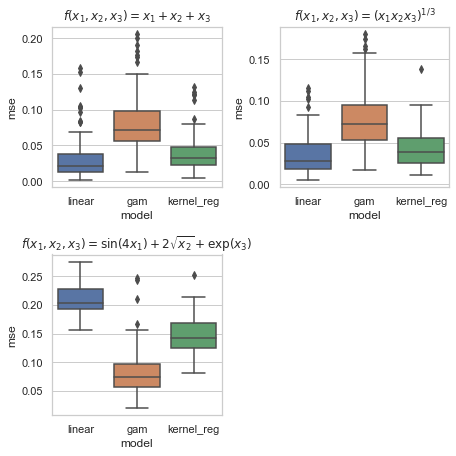

In [317]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6.5, 6.5))
sns.boxplot(x='model', y='mse', data=trials[trials['f'] == 'linear'], ax=axes[0][0])
sns.boxplot(x='model', y='mse', data=trials[trials['f'] == 'geo_mean'], ax=axes[0][1])
sns.boxplot(x='model', y='mse', data=trials[trials['f'] == 'nonlinear'], ax=axes[1][0])
axes[0][0].set_title('$f(x_1, x_2, x_3) = x_1 + x_2 + x_3$')
axes[1][0].set_title('$f(x_1, x_2, x_3) = \sin(4x_1) + 2\sqrt{x_2} + \exp(x_3)$')
axes[0][1].set_title('$f(x_1, x_2, x_3) = (x_1 x_2 x_3)^{1/3}$')
axes[1][1].axis('off')
fig.tight_layout()
fig.savefig('mse.pdf')